In [1]:
import os
import numpy as np

In [2]:
root_folder = "/groups/assafza_group/assafza/Gad/Cell_Cycle_Data"

In [3]:
# Example:
bf = np.load("/groups/assafza_group/assafza/Gad/Cell_Cycle_Data/train/images/0503.1001.npy")[0,0] # T, C, Y, X
target = np.load("/groups/assafza_group/assafza/Gad/Cell_Cycle_Data/train/labels/0503.1001.npy")[:, 0] # C, T, 1
print(bf.shape)
print(target.shape)


(64, 64)
(2, 1)


In [37]:
target

array([[0.8477],
       [0.2588]], dtype=float16)

In [38]:
# ---------- preprocessing & inference ----------
import glob

IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1)
IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1)

def compute_bf_mean_std_robust(root, split="train", bf_channel=0,
                               sample_videos=200, sample_frames=50):
    img_dir = os.path.join(root, split, "images")
    files = [f for f in sorted(os.listdir(img_dir)) if f.endswith(".npy")]
    files = files[:min(sample_videos, len(files))]
    n = 0; mean = 0.0; M2 = 0.0
    for fname in files:
        arr = np.load(os.path.join(img_dir, fname), mmap_mode="r")  # (T,C,H,W)
        if arr.size == 0: continue
        T = arr.shape[0]
        idx = np.random.choice(T, size=min(sample_frames, T), replace=False)
        bf = arr[idx, bf_channel].astype(np.float64, copy=False).ravel()
        x = bf[np.isfinite(bf)]
        for v in x:
            n += 1
            delta = v - mean
            mean += delta / n
            M2 += delta * (v - mean)
    if n < 2: return 0.0, 1.0
    var = max(M2 / (n - 1), 1e-12)
    return float(mean), float(var**0.5)

def preprocess_bf(frames_thw, mode, device, ds_mean_std=None):
    """
    frames_thw: (T,H,W) float in [0,1] or raw scale
    mode: 'imagenet' | 'dataset' | 'pertrack'
    ds_mean_std: (mean, std) from compute_bf_mean_std_robust (needed for 'dataset')
    """
    x = torch.from_numpy(frames_thw).float().unsqueeze(1).repeat(1,3,1,1).to(device)  # (T,3,H,W)
    if mode == "imagenet":
        x = (x - IMAGENET_MEAN.to(device)) / (IMAGENET_STD.to(device) + 1e-6)
    elif mode == "dataset":
        assert ds_mean_std is not None, "dataset mode requires ds_mean_std"
        m, s = ds_mean_std
        ms = torch.tensor([m, m, m], device=device).view(1,3,1,1)
        ss = torch.tensor([max(s,1e-6)]*3, device=device).view(1,3,1,1)
        x = (x - ms) / ss
    elif mode == "pertrack":
        m = x.mean(dim=(2,3), keepdim=True)
        s = x.std(dim=(2,3), keepdim=True).clamp_min(1e-6)
        x = (x - m) / s
    else:
        raise ValueError("mode must be imagenet|dataset|pertrack")
    return x

def preprocess_bf_3ch(bf_thw: np.ndarray, device):
    x = torch.from_numpy(bf_thw).float().unsqueeze(1).repeat(1,3,1,1)  # (T,3,H,W)
    x = (x.to(device) - IMAGENET_MEAN.to(device)) / (IMAGENET_STD.to(device) + 1e-6)
    return x

@torch.no_grad()
# def infer_video(model, video_np, bf_channel=0, batch=512, device="cpu"):
def infer_video(model, video_np, bf_channel=0, batch=512, device="cpu", norm_mode="imagenet", ds_mean_std=None):
    model.eval()
    bf = video_np[:, bf_channel]                     # (T,H,W)
    # X = preprocess_bf_3ch(bf, device)
    outs = []
    # for i in range(0, X.shape[0], batch):
    for i in range(0, bf.shape[0], batch):
        X = preprocess_bf(bf[i:i+batch], mode=norm_mode, device=device, ds_mean_std=ds_mean_std)
        preds = model(X)
        preds = preds[0] if isinstance(preds, (tuple,list)) else preds
        outs.append(preds.detach().cpu())
        preds = model(X[i:i+batch].to(device))
        # if isinstance(preds, (tuple, list)):         # just in case the forward returns extras
        #     preds = preds[0]
        # outs.append(preds.detach().cpu())
    return torch.cat(outs, dim=0).numpy()            # (T,2)

def collect_test_arrays(ROOT, CKPT=None, model_obj=None, bf_channel=0, device=None, norm_mode="imagenet", ds_mean_std=None):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")

    # accept either a checkpoint path or a preloaded model (or a tuple (model, mean, std))
    if model_obj is None:
        mdl = load_original_model(CKPT, device=device)
        print("Loaded model")
    else:
        mdl = model_obj
    if isinstance(mdl, (tuple, list)):               # <- unwrap (model, mean, std)
        mdl = mdl[0]
    mdl = mdl.to(device)

    img_dir = os.path.join(ROOT, "test", "images")
    lbl_dir = os.path.join(ROOT, "test", "labels")
    files = sorted(glob.glob(os.path.join(img_dir, "*.npy")))

    preds_all, trues_all = [], []
    for path in files:
        name = os.path.basename(path)
        vid = np.load(path, mmap_mode="r")                            # (T,C,64,64)
        pred = infer_video(mdl, vid, bf_channel, device=device, norm_mode=norm_mode, ds_mean_std=ds_mean_std)       # (T,2)

        y = np.load(os.path.join(lbl_dir, name), mmap_mode="r")       # (2,T,1)
        true = y[:, :, 0].T                                           # (T,2)

        preds_all.append(pred.astype(np.float32))
        trues_all.append(true.astype(np.float32))

        if len(preds_all) % 200 == 0:
            print("Did 200 predictions")

    Y_pred = np.concatenate(preds_all, axis=0)
    Y_true = np.concatenate(trues_all, axis=0)
    return Y_pred, Y_true


In [39]:
# compute dataset stats from TRAIN split (not test!)
ds_mean_std = compute_bf_mean_std_robust(root_folder, split="train", bf_channel=0)

In [40]:
# # run once with imagenet, once with dataset z-score, once with pertrack to see what was used in the original pipeline
# Yp_img, Yt = collect_test_arrays(root_folder, ckpt, bf_channel=0)  # this calls infer_video internally — adjust that function to pass norm_mode

# # For a quick comparison, modify collect_test_arrays to accept **infer_kwargs and forward them:
# # pred = infer_video(mdl, vid, bf_channel, device=device, **infer_kwargs)

# Yp_ds, _  = collect_test_arrays(root_folder, ckpt, bf_channel=0, norm_mode="dataset", ds_mean_std=ds_mean_std)
# Yp_pt, _  = collect_test_arrays(root_folder, ckpt, bf_channel=0, norm_mode="pertrack", ds_mean_std=ds_mean_std)

# def mae(a,b): return float(np.mean(np.abs(a-b)))
# print("MAE imagenet :", mae(Yp_img, Yt))
# print("MAE dataset  :", mae(Yp_ds, Yt))
# print("MAE pertrack :", mae(Yp_pt, Yt))


In [41]:
Y_pred, Y_true = collect_test_arrays(root_folder, ckpt, bf_channel=0, norm_mode="dataset", ds_mean_std=ds_mean_std)
print("Pred shape:", Y_pred.shape, "True shape:", Y_true.shape)
print("MAE (quick sanity):", np.mean(np.abs(Y_pred - Y_true)))

Loaded model
Did 200 predictions
Pred shape: (87424, 2) True shape: (87424, 2)
MAE (quick sanity): 0.16958852


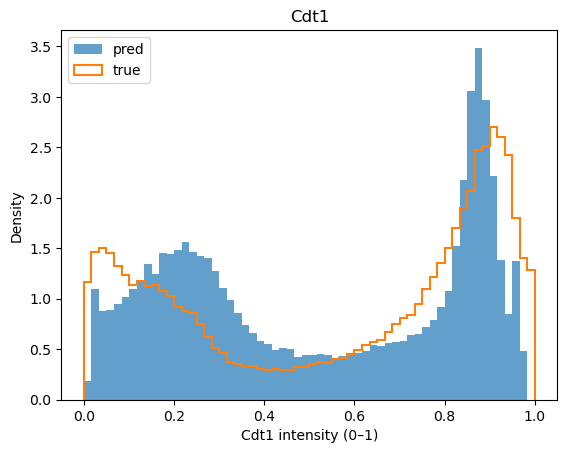

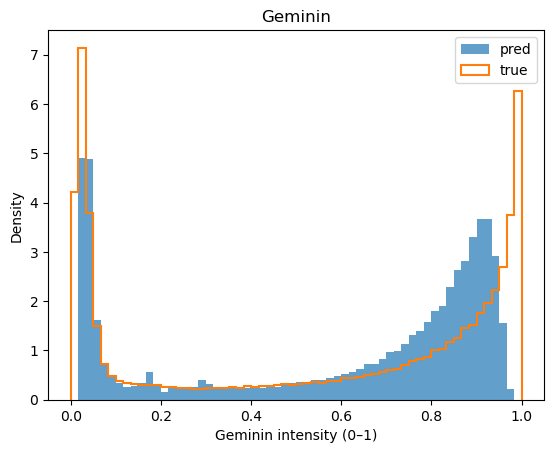

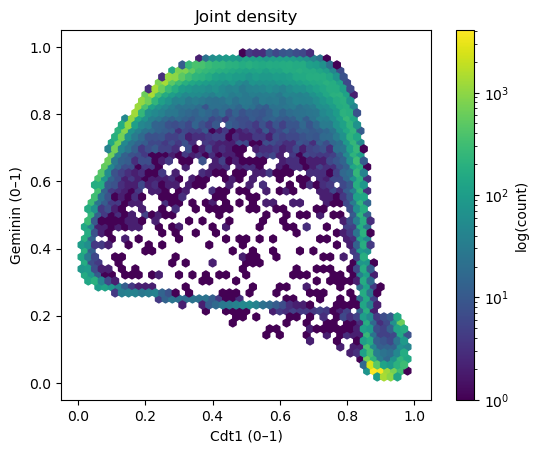

In [42]:
import numpy as np
import matplotlib.pyplot as plt

def plot_pred_distributions_01(Y_pred, Y_true=None, bins=60, title_prefix=""):
    """
    Y_pred: (N,2) in [0,1]   -> [Cdt1, Geminin]
    Y_true: optional (N,2)   -> overlay as outline
    """
    # clamp just in case
    P = np.clip(Y_pred.astype(float), 0.0, 1.0)
    T = np.clip(Y_true.astype(float), 0.0, 1.0) if Y_true is not None else None

    # 1) Cdt1 histogram
    fig, ax = plt.subplots()
    ax.hist(P[:,0], bins=bins, range=(0,1), density=True, alpha=0.7, label="pred")
    if T is not None:
        ax.hist(T[:,0], bins=bins, range=(0,1), density=True, histtype="step", linewidth=1.5, label="true")
    ax.set(xlabel="Cdt1 intensity (0–1)", ylabel="Density", title=f"{title_prefix}Cdt1")
    ax.legend(); plt.show()

    # 2) Geminin histogram
    fig, ax = plt.subplots()
    ax.hist(P[:,1], bins=bins, range=(0,1), density=True, alpha=0.7, label="pred")
    if T is not None:
        ax.hist(T[:,1], bins=bins, range=(0,1), density=True, histtype="step", linewidth=1.5, label="true")
    ax.set(xlabel="Geminin intensity (0–1)", ylabel="Density", title=f"{title_prefix}Geminin")
    ax.legend(); plt.show()

    # 3) Joint distribution (2D)
    fig, ax = plt.subplots()
    hb = ax.hexbin(P[:,0], P[:,1], gridsize=50, extent=(0,1,0,1), bins="log")
    cb = fig.colorbar(hb, ax=ax); cb.set_label("log(count)")
    ax.set(xlabel="Cdt1 (0–1)", ylabel="Geminin (0–1)", title=f"{title_prefix}Joint density")
    ax.set_aspect("equal")
    plt.show()

# example:
plot_pred_distributions_01(Y_pred, Y_true=Y_true, bins=60)


In [43]:
STAGE_NAMES = {0:"G1", 1:"S", 2:"G2"}

def stages_from_fucci_rule(y,
                           r_g1=1.4,     # G1 requires f1 >= r_g1 * f2
                           r_g2=2.1,     # G2 requires f2 >= r_g2 * f1  (bigger -> fewer G2)
                           min_signal=0.05,
                           bias=0.10,    # +bias favors G1 (reduces G2 overcalls)
                           eps=1e-8):
    y = np.asarray(y, dtype=np.float32)
    f1, f2 = y[:, 0], y[:, 1]

    # 'both low' -> keep as S (or change later if you want explicit M)
    both_low = (f1 < min_signal) & (f2 < min_signal)

    # log-ratio (linear inputs), with bias:
    # lr = log(f1/f2) + bias
    lr = np.log(f1 + eps) - np.log(f2 + eps) + bias
    d1 = np.log(r_g1)
    d2 = np.log(r_g2)

    stages = np.full(len(y), 1, dtype=np.int64)         # default S
    stages[(lr >=  d1) & ~both_low] = 0                 # G1
    stages[(lr <= -d2) & ~both_low] = 2                 # G2
    return stages

def class_counts(stages, n_classes=3):
    """stages: 1D int array of {0,1,2}. Returns dict of counts and percents."""
    stages = np.asarray(stages, dtype=np.int64)
    # sanity: clamp unexpected labels
    if stages.min() < 0 or stages.max() >= n_classes:
        raise ValueError(f"Stage ids must be in [0,{n_classes-1}], got [{stages.min()},{stages.max()}].")
    counts = np.bincount(stages, minlength=n_classes)
    total = counts.sum()
    perc = counts / max(total, 1)
    return {STAGE_NAMES[i]: int(counts[i]) for i in range(n_classes)}, \
           {STAGE_NAMES[i]: float(perc[i])  for i in range(n_classes)}

def per_class_accuracy(y_true, y_pred):
    acc = {}
    for k, name in STAGE_NAMES.items():
        mask = (y_true == k)
        acc[name] = float((y_pred[mask] == k).mean()) if mask.any() else np.nan
    acc["macro"] = float(np.nanmean([acc["G1"], acc["S"], acc["G2"]]))
    acc["overall"] = float((y_true == y_pred).mean())
    return acc

pred_stage = stages_from_fucci_rule(
    Y_pred, r_g1=1.35, r_g2=2.35, min_signal=0.05, bias=0.2
)
true_stage = stages_from_fucci_rule(
    Y_true, r_g1=1.35, r_g2=2.35, min_signal=0.05, bias=0.2
)

pred_counts, pred_perc = class_counts(pred_stage)
true_counts, true_perc = class_counts(true_stage)
acc = per_class_accuracy(true_stage, pred_stage)

print("Pred %:", {k: f"{v*100:.1f}%" for k,v in pred_perc.items()})
print("True %:", {k: f"{v*100:.1f}%" for k,v in true_perc.items()})
print(acc)

Pred %: {'G1': '33.8%', 'S': '29.3%', 'G2': '36.9%'}
True %: {'G1': '39.8%', 'S': '27.0%', 'G2': '33.1%'}
{'G1': 0.7200689061154177, 'S': 0.5325861704377247, 'G2': 0.8005112439117068, 'macro': 0.6843887734882831, 'overall': 0.6959988103953147}


In [44]:
def _probe_len(path):
    import numpy as np
    try:
        arr = np.load(path, mmap_mode="r")
        return os.path.basename(path), int(arr.shape[0])
    except Exception:
        return os.path.basename(path), 0

def build_sample_map(root, split="train", frames_per_video=50, deterministic=True, seed=0, out_path=None):
    img_dir = os.path.join(root, split, "images")
    files = sorted(glob.glob(os.path.join(img_dir, "*.npy")))
    if not files:
        raise FileNotFoundError(f"No .npy in {img_dir}")

    # parallel header probe
    with Pool(processes=max(1, cpu_count() - 1)) as pool:
        lengths = dict(pool.map(_probe_len, files))

    rng = np.random.RandomState(seed)
    sample_map = []  # list of {"file": name, "t": int}
    for p in files:
        name = os.path.basename(p)
        T = int(lengths.get(name, 0))
        if T <= 0: 
            continue
        if deterministic:
            idxs = np.linspace(0, T-1, num=min(frames_per_video, T), dtype=int)
        else:
            idxs = rng.choice(T, size=min(frames_per_video, T), replace=False)
        for t in idxs:
            sample_map.append({"file": name, "t": int(t)})

    out_path = out_path or os.path.join(root, split, "sample_map.json")
    with open(out_path, "w") as f:
        json.dump(sample_map, f)
    return out_path

# bf_frames_labels_fast.py
import os, json, numpy as np, torch
from torch.utils.data import Dataset

class BFFramesWithLabelsFast(Dataset):
    """
    Uses a precomputed JSON sample map created by build_sample_map(...).
    Returns:
      x:  FloatTensor (1,H,W)  normalized with provided (mean,std)
      y:  FloatTensor (2,)     ground-truth [Cdt1, Geminin] in [0,1]
    """
    def __init__(self, root, split="train", bf_channel=0, mean=0.0, std=1.0,
                 sample_map_path=None, return_meta=False):
        self.root = root
        self.split = split
        self.img_dir = os.path.join(root, split, "images")
        self.lbl_dir = os.path.join(root, split, "labels")
        if not sample_map_path:
            raise ValueError("Provide sample_map_path (build it once with build_sample_map).")
        with open(sample_map_path, "r") as f:
            self.sample_map = json.load(f)
        if not self.sample_map:
            raise RuntimeError("Empty sample map.")
        self.bf_channel = bf_channel
        self.mean, self.std = float(mean), max(float(std), 1e-6)
        self.return_meta = return_meta

    def __len__(self):
        return len(self.sample_map)

    def __getitem__(self, i):
        item = self.sample_map[i]
        fname, t = item["file"], int(item["t"])
    
        # load frame and z-score (single-channel BF)
        vid = np.load(os.path.join(self.img_dir, fname), mmap_mode="r")   # (T,C,H,W)
        frame = vid[t, self.bf_channel].astype(np.float32)                # (H,W)
        x1 = torch.from_numpy(frame)                                      # (H,W)
        x1 = (x1 - self.mean) / max(self.std, 1e-6)                       # z-score
        x = x1.unsqueeze(0).repeat(3, 1, 1)                               # -> (3,H,W)
    
        # load label → (2,)
        lbl = np.load(os.path.join(self.lbl_dir, fname), mmap_mode="r")   # (2,T,1) or (2,T)
        if lbl.ndim == 3 and lbl.shape[2] == 1:
            y_np = lbl[:, t, 0].astype(np.float32)
        elif lbl.ndim == 2:
            y_np = lbl[:, t].astype(np.float32)
        else:
            raise ValueError(f"Unexpected label shape for {fname}: {lbl.shape}")
        y = torch.from_numpy(y_np)                                        # (2,)
    
        if self.return_meta:
            return x, y, {"file": fname, "t": t}
        return x, y


In [46]:
# Load train
m, s = ds_mean_std
sample_map_train_path = "/groups/assafza_group/assafza/Gad/Cell_Cycle_Data/train/sample_map.json"
train_ds = BFFramesWithLabelsFast(root_folder, split="train", bf_channel=0,
                            mean=m, std=s, sample_map_path=sample_map_train_path,
                            return_meta=False)

In [47]:
len(train_ds)

1104591